In [1]:
from collections import Counter

import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('ticks')

import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [2]:
#Load the data
df = pd.read_csv('./data/allbcs.csv',index_col=0)

### Assign functional subtypes

Assigns each barcode to a phenotypic subtype dependent on which replicates the barcode exhibits positive growth rate in. 

In [3]:
#Growth rate limit
k_lim=0.0

#Assign the 'phenotype' to each barcode
def label(x):
    if sum(x[3:]) >=1 and sum(x[:3])>=1:
        return 3 #Double res
    elif sum(x[:3])>=2 and sum(x[3:])==0:
        return 2 #Gef res
    elif sum(x[3:])>=2 and sum(x[:3])==0:
        return 1 #Trm res
    elif sum(x)==1:
        return -1 #Potentially de novo
    elif sum(x)==0:
        return 0 #Sensitive
    else: 
        return -2 #Undetermined

df['type']=(df[[c for c in df.columns if '_r' in c and 'DMSO' not in c]] > k_lim).apply(label, axis=1)


#Setting the 'undetermined' phenotype where it is not present in either control
df['type'][df[['DMSO7' , 'DMSO8']].max(axis=1) == 0] = -2

d_num=(df['type']==3).sum()
g_num=(df['type']==2).sum()
t_num=(df['type']==1).sum()

### Basic summary statistics

In [4]:
print "GEFr freq in POT:", 100*df[df['type']==2]['POT'].sum() / df['POT'].sum()
print "TRMr freq in POT:", 100*df[df['type']==1]['POT'].sum() / df['POT'].sum()
print "Doubler freq in POT:", 100*df[df['type']==3]['POT'].sum() / df['POT'].sum()
print "Resistance (any type) freq in POT:", 100*df[df['type']>0]['POT'].sum() / df['POT'].sum()

GEFr freq in POT: 2.401010080102664
TRMr freq in POT: 0.5654102760471647
Doubler freq in POT: 0.9134877431195192
Resistance (any type) freq in POT: 3.8799080992693478


In [5]:
print "GEFr frequency in GEF lines (avg):", 100*((df[df['type']==2][['GEF1', 'GEF2', 'GEF3']] /
                                              df[['GEF1', 'GEF2', 'GEF3']].sum()).sum()).mean()
print "TRMr frequency in GEF lines (avg):", 100*((df[df['type']==1][['GEF1', 'GEF2', 'GEF3']] / df[['GEF1', 'GEF2', 'GEF3']].sum()).sum()).mean()
print "Doubler frequency in GEF lines (avg):", 100*((df[df['type']==3][['GEF1', 'GEF2', 'GEF3']] / df[['GEF1', 'GEF2', 'GEF3']].sum()).sum()).mean()

GEFr frequency in GEF lines (avg): 32.817991177912134
TRMr frequency in GEF lines (avg): 0.3343463659023063
Doubler frequency in GEF lines (avg): 22.388379763210796


In [6]:
print "GEFr frequency in TRM lines (avg):", 100*((df[df['type']==2][['TRM4', 'TRM5', 'TRM6']] /
                                              df[['TRM4', 'TRM5', 'TRM6']].sum()).sum()).mean()
print "TRMr frequency in TRM lines (avg):", 100*((df[df['type']==1][['TRM4', 'TRM5', 'TRM6']] / df[['TRM4', 'TRM5', 'TRM6']].sum()).sum()).mean()
print "Doubler frequency in TRM lines (avg):", 100*((df[df['type']==3][['TRM4', 'TRM5', 'TRM6']] / df[['TRM4', 'TRM5', 'TRM6']].sum()).sum()).mean()

GEFr frequency in TRM lines (avg): 0.13200505781501237
TRMr frequency in TRM lines (avg): 4.20920215777881
Doubler frequency in TRM lines (avg): 86.12471991201393


### Creating the plot color scheme

In [7]:
#Barcode colors
cs = sns.xkcd_palette(['dark red', 'blue', 'grey',
                        'sky blue', 'pale red', 'sage', 'dark purple',
                        'purple', 'gold', 'sienna', 'dark red', 'navy blue', 
                        'turquoise', 'dark green', 'sage', 'cream']) + sns.color_palette("muted", 5)

cs2 = sns.color_palette("muted", 12)
gef_cs = sns.color_palette("dark", g_num)
trm_cs = sns.color_palette("colorblind", t_num)

#Phenotype cols
double_res_c = sns.xkcd_rgb['tangerine']
gef_res_c = sns.xkcd_rgb['denim blue']
trm_res_c = sns.xkcd_rgb['pale purple']
dn_res_c = sns.xkcd_rgb['green']
abs_col='#d9d9d9'

#Change this colour to explicitly highlight undetermined BCs
#in the barchart plot.
und_col='#d9d9d9'#sns.xkcd_rgb['dark grey']

col_list = [abs_col, trm_res_c, gef_res_c, double_res_c, und_col, dn_res_c]

In [8]:
#Register the colors for each barcodes
new_column = []
ck, ck2, gk, tk = 0,0,0,0
for ix in df.index:
    if df['type'].loc[ix]==3:
        if df['TRM4_r'].loc[ix]<0.015:
            new_column.append(cs2[ck2 % len(cs2)])
            ck2+=1
        else:
            new_column.append(cs[ck % len(cs)])
            ck+=1
    elif df['type'].loc[ix]==2:
        new_column.append(gef_cs[gk % len(gef_cs)])
        gk+=1
    elif df['type'].loc[ix]==1:
        new_column.append(trm_cs[tk % len(trm_cs)])
        tk+=1
    elif df['type'].loc[ix]==5:
        new_column.append(dn_res_c)
    else:
        new_column.append(abs_col)
    

df['color'] = new_column

In [9]:
# sort the dataframe
df = df.sort_values('type', ascending=False)

# Uncomment this line to test plots quickly
# df=df.head(1000)

### Plot the mapping from number of replicates with r>0 to phenotype space

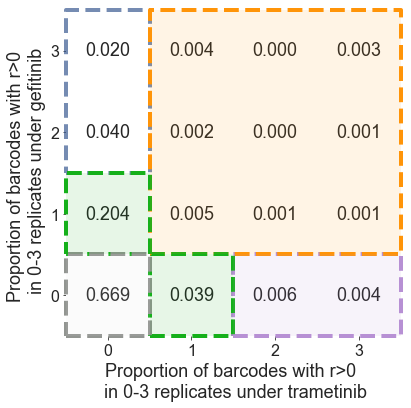

In [10]:
gs_cnts=(df[[c for c in df.columns if '_r' in c and 'DMSO' not in c and 'GEF' in c]] > k_lim).sum(axis=1).values
ts_cnts=(df[[c for c in df.columns if '_r' in c and 'DMSO' not in c and 'TRM' in c]] > k_lim).sum(axis=1).values
counts=Counter(zip(gs_cnts, ts_cnts))

mat = np.zeros((4,4))
for k,v in counts.items():
    mat[k]=float(v)
    
mat = mat/mat.sum()
plt.figure(figsize=(6,6))
sns.heatmap(mat,annot=True, cbar=False, fmt='.3f', cmap=ListedColormap(['white']), annot_kws={"size": 18})

#Phenotype highlight
rect1 = Rectangle((0, 2), 1,2)
rect2 = Rectangle((1, 1), 3,3)
rect3 = Rectangle((2, 0), 2,1)
rect4 = Rectangle((0, 1), 1,1)
rect5 = Rectangle((1, 0), 1,1)
rect7 = Rectangle((0,0), 1,1)


lw=4.0
ls='--'
# Create patch collection with specified colour/alpha
pc = PatchCollection([rect1], facecolor='', alpha=0.7, clip_on=False,
                     edgecolor='k', lw=lw, color=gef_res_c, linestyle=ls, zorder=40)

pc2 = PatchCollection([rect3], facecolor='', alpha=1.0, clip_on=False,
                     edgecolor='k', lw=lw, color=trm_res_c, linestyle=ls, zorder=40)

pc3 = PatchCollection([rect2], facecolor='', alpha=1.0, clip_on=False,
                     edgecolor='k', lw=lw, color=double_res_c, linestyle=ls, zorder=40)

pc4 = PatchCollection([rect4, rect5], facecolor='', alpha=1.0, clip_on=False,
                     edgecolor=sns.xkcd_rgb['green'], lw=lw, linestyle=ls, zorder=40)

pc5 = PatchCollection([rect7], facecolor='', alpha=1.0, clip_on=False,
                     edgecolor=sns.xkcd_rgb['grey'], lw=lw, linestyle=ls, zorder=40)

plt.gca().add_collection(pc)
plt.gca().add_collection(pc2)
plt.gca().add_collection(pc3)
plt.gca().add_collection(pc4)
plt.gca().add_collection(pc5)

# Create patch collection with specified colour/alpha
alpha = 0.1
pc = PatchCollection([rect1], facecolor=gef_res_c, alpha=alpha, clip_on=False,
                     edgecolor='k', lw=0., color=gef_res_c, linestyle='--', zorder=40)

pc2 = PatchCollection([rect3], facecolor=trm_res_c, alpha=alpha, clip_on=False,
                     edgecolor='k', lw=0., color=trm_res_c, linestyle='--', zorder=40)

pc3 = PatchCollection([rect2], facecolor=double_res_c, alpha=alpha, clip_on=False,
                     edgecolor='k', lw=0., color=double_res_c, linestyle='--', zorder=40)

pc4 = PatchCollection([rect4, rect5], facecolor=dn_res_c, alpha=alpha, clip_on=False,
                     edgecolor=sns.xkcd_rgb['green'], lw=0., linestyle='--', zorder=40)

pc5 = PatchCollection([rect7], facecolor=abs_col, alpha=alpha, clip_on=False,
                     edgecolor=sns.xkcd_rgb['grey'], lw=0., linestyle='--', zorder=40)

plt.gca().add_collection(pc2)
plt.gca().add_collection(pc3)
plt.gca().add_collection(pc4)
plt.gca().add_collection(pc5)


#Axes and labelling
plt.yticks(size=16, rotation=0)
plt.ylabel('Proportion of barcodes with r>0 \n in 0-3 replicates under gefitinib',size=18)
plt.xticks(size=16)
plt.xlabel('Proportion of barcodes with r>0 \n in 0-3 replicates under trametinib',size=18)
# plt.title('Barcode Phenotype Legend', size=20, y=1.01)

plt.gca().invert_yaxis()
plt.show()

### Stacked Frequency Plot

Note this plotting function is very slow (sorry).

0.07919883537212206


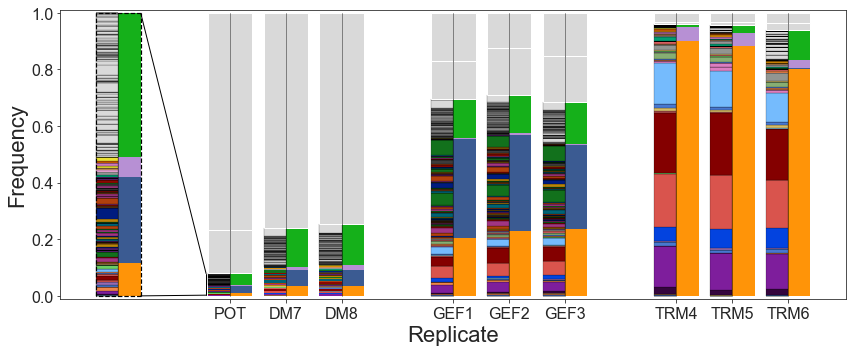

In [11]:
#Frequency plot
plt.figure(figsize=(12,5))
for loc, name in enumerate(['POT', 'POT', 'DMSO7', 'DMSO8', 'GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6']):
    tot,und_tot = 0,0
    ec = 'k'
    if loc==0:
        vals=[]
        for ix in df.index:
            if df['type'].loc[ix]>0 or df['type'].loc[ix]==-1:
                vals.append((ix, df[name][ix]))
                
        s=float(sum(map(lambda x : x[1], vals)))
        print s / df[name].sum()
        for ix,val in vals:
            c=df['color'].loc[ix]
            c2=col_list[df['type'].loc[ix]]
            plt.bar([loc-1-0.2],[val/s], bottom=tot, facecolor=c,edgecolor = 'k',width=0.4, linewidth=0.2)
            plt.bar([loc-1+0.2],[val/s], bottom=tot, facecolor=c2, edgecolor = 'k',width=0.4, linewidth=0.)
            tot+=val/s
        plt.plot([loc-1, loc-1], [0,1],ls='-', c='k', lw=0.5)

    elif loc in [1,2,3]:
        for ix in df.index:
            if df['type'].loc[ix]>0 or df['type'].loc[ix]==-1:
                val=df[name][ix] / df[name].sum()
                c=df['color'].loc[ix]
                c2=col_list[df['type'].loc[ix]]
                lww = 0.0 if df['type'].loc[ix]>0 else 0.2
                plt.bar([loc-0.2],[val], bottom=tot, facecolor=c,edgecolor = 'k',width=0.4, linewidth=lww)
                plt.bar([loc+0.2],[val], bottom=tot, facecolor=c2, edgecolor = 'k',width=0.4, linewidth=0.)
                tot+=val
            if df['type'].loc[ix] == -2:
                und_tot +=df[name][ix] / df[name].sum()
        
        
        plt.bar([loc-0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)
        plt.bar([loc+0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)

        plt.bar([loc-0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.bar([loc+0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.plot([loc, loc], [0,1],ls='-', c='k', lw=0.5)    

    elif loc<7:
        for ix in df.index:
            if df['type'].loc[ix]>0 or df['type'].loc[ix]==-1:
                val=df[name][ix] / df[name].sum()
                c=df['color'].loc[ix]
                c2=col_list[df['type'].loc[ix]]
                plt.bar([loc+1-0.2],[val], bottom=tot, facecolor=c,edgecolor = 'k',width=0.4, linewidth=0.2)
                plt.bar([loc+1+0.2],[val], bottom=tot, facecolor=c2, edgecolor = 'k',width=0.4, linewidth=0.)
                tot+=val
            if df['type'].loc[ix] == -2:
                und_tot +=df[name][ix] / df[name].sum()
        
        
        plt.bar([loc+1-0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)
        plt.bar([loc+1+0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)

        plt.bar([loc+1-0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.bar([loc+1+0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.plot([loc+1, loc+1], [0,1],ls='-', c='k', lw=0.5)    

    else:
        for ix in df.index:
            if df['type'].loc[ix]>0 or df['type'].loc[ix]==-1:
                val=df[name][ix] / df[name].sum()
                c=df['color'].loc[ix]
                c2=col_list[df['type'].loc[ix]]
                plt.bar([loc+2-0.2],[val], bottom=tot, facecolor=c,edgecolor = 'k',width=0.4, linewidth=0.2)
                plt.bar([loc+2+0.2],[val], bottom=tot, facecolor=c2, edgecolor = 'k',width=0.4, linewidth=0.)
                tot+=val
            
            if df['type'].loc[ix] == -2:
                und_tot +=df[name][ix] / df[name].sum()
        
        
        plt.bar([loc+2-0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)
        plt.bar([loc+2+0.2],[1.-und_tot-tot],bottom=tot, facecolor=abs_col,width=0.4)

        plt.bar([loc+2-0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.bar([loc+2+0.2],[und_tot],bottom=1.-und_tot, facecolor=und_col,width=0.4)
        plt.plot([loc+2, loc+2], [0,1],ls='-', c='k', lw=0.5)    

#annotation
span=0.079
plt.plot([0.57, -0.6], [span,1-0.0025], ls='-', c='k', lw=1.0)
plt.plot([0.57, -0.6], [0.0025, 0.0], ls='-', c='k', lw=1.0)
plt.plot([0.57, 0.57], [0.0025, span], ls='-', c='k', lw=1.0)
plt.plot([-0.6, -0.6], [0.0, 1.0], ls='--', c='k', lw=1.2)
plt.plot([-1.4, -1.4], [0.0, 1.0], ls='--', c='k', lw=1.2)
plt.plot([-0.6, -1.4], [0.0, 0.0], ls='--', c='k', lw=1.2)
plt.plot([-0.6, -1.4], [1.0, 1.0], ls='--', c='k', lw=1.2)

plt.xticks([1,2,3,5,6,7,9,10,11], ['POT', 'DM7', 'DM8', 'GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6'], size=16)
plt.yticks(size=16)
plt.ylabel('Frequency', size=22)
plt.xlabel('Replicate', size=22)
plt.ylim(-0.01,1.01)
plt.tight_layout()
plt.show()

### Temporal Frequency Plots

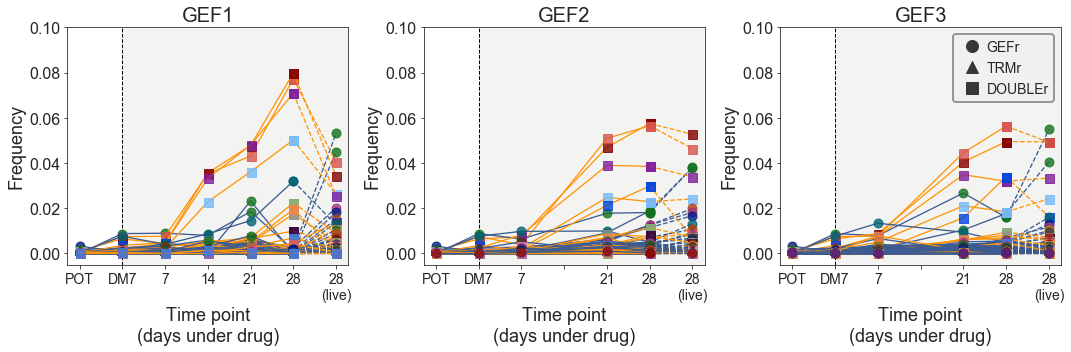

In [12]:
#Params
ms=9
mr='o'
ls=''
lw=1.3

tots1=df[[c for c in df.columns if 'G1_f' in c or 'GEF1' == c]].sum()
tots2=df[[c for c in df.columns if 'G2_f' in c or 'GEF2' == c]].sum()
tots3=df[[c for c in df.columns if 'G3_f' in c or 'GEF3' == c]].sum()

#Correct the frequency calc for the skipped time points
tots2[tots2==0]=1
tots3[tots3==0]=1
freqs_pot = df['POT']/df['POT'].sum()
freqs_dm = df['DMSO7']/df['DMSO7'].sum()

ck = 0
coldict={}
plt.figure(figsize=(15,5))
for i, ix in enumerate(df.index):

    freqs_1 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'G1_f' in c or 'GEF1' == c]].loc[ix].values, tots1))
    freqs_2 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'G2_f' in c or 'GEF2' == c]].loc[ix].values, tots2))
    freqs_3 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'G3_f' in c or 'GEF3' == c]].loc[ix].values, tots3))    

    #For the markers
    typ  = df['type'][ix]
    c_bc = df['color'][ix]
    c_type=col_list[typ]
    
    # cswap - Comment out this line to swap the marker and line colours
    c_bc, c_type = c_type, c_bc
    
    for k in range(3):
        freqs = [freqs_1, freqs_2, freqs_3][k]
        plt.subplot(1,3,k+1)
        if k==0:
            dom = [0,7,14,21,28,35,42]
            vals=freqs
        else:
            dom=[0,7,14,28,35,42]
            vals=freqs[:3]+freqs[4:]
        if freqs[-1]>0.0:
            if typ==3:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', lw=lw, zorder=1-vals[-1])
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='s', ms=ms, ls='', zorder=1-vals[-1], alpha=0.8) 
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='--', lw=lw, zorder=1-vals[-1])
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='s', ms=ms, ls='', zorder=1-vals[-1], alpha=0.8)  
            elif typ==2:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw, zorder=1-vals[-1])
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='o', ms=ms,ls='', zorder=1-vals[-1], alpha=0.8)
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='--', alpha=1.0, lw=lw, zorder=1-vals[-1])
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='o', ms=ms,ls='', zorder=1-vals[-1], alpha=0.8)
            elif typ==1:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw, zorder=0)
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='^', ms=ms,ls='', alpha=1.0, zorder=0)
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='--', alpha=1.0, lw=lw, zorder=0)
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='^', ms=ms,ls='', alpha=1.0, zorder=0)
        plt.ylim(10**(-5),1.0)
        

#Hack a legend
plt.subplot(133)
plt.plot([-10], [-10], c=sns.xkcd_rgb['dark grey'], marker='o', ms=12, label='GEFr', ls='')
plt.plot([-10], [-10], c=sns.xkcd_rgb['dark grey'], marker='^', ms=12, label='TRMr', ls='')
plt.plot([-10], [-10], c=sns.xkcd_rgb['dark grey'], marker='s', ms=12, label='DOUBLEr', ls='')

legend=plt.legend(fontsize=14, loc='upper right', handletextpad=0., frameon=True)
frame = legend.get_frame()
frame.set_color('#f0f0f0')
frame.set_edgecolor('#969696')
frame.set_linewidth(2.)
frame.set_alpha(1.0)
#Labelling
for k in range(1,4):                
    plt.subplot(1,3,k)
    
    plt.axvline(7, ls='--', c='k', lw=1.0, zorder=0)
    plt.axvspan(7,50, facecolor=sns.xkcd_rgb['light grey'], zorder=0, alpha=0.3)
    plt.ylabel('Frequency', size=18)
    plt.xlabel('Time point\n(days under drug)', size=18)
    
    dom = [0,7,14,21,28,35,42]
    tick_labels = ['POT']+['DM7']+[str(i-7) for i in dom[2:-1]]+['28\n(live)']

    if k==2 or k==3:
        tick_labels=tick_labels[:3] + [""]+ tick_labels[4:]
    
    plt.xticks(dom, tick_labels, size=14,)
    plt.yticks(size=16)
    plt.ylim(-0.005,0.1)
    plt.xlim(-2.,44)
    plt.title('GEF'+str(k), size=20)
    

plt.tight_layout()
plt.show()

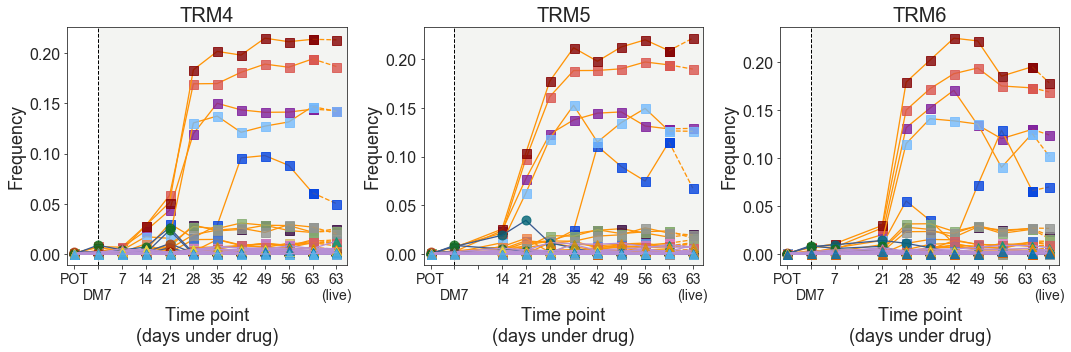

In [13]:
#Params
ms=9
mr='o'
ls=''
lw=1.3

tots1=df[[c for c in df.columns if 'T4_f' in c or 'TRM4' == c]].sum()
tots2=df[[c for c in df.columns if 'T5_f' in c or 'TRM5' == c]].sum()
tots3=df[[c for c in df.columns if 'T6_f' in c or 'TRM6' == c]].sum()


#Correct the frequency calc for the skipped time points
tots2[tots2==0]=1
tots3[tots3==0]=1
freqs_pot = df['POT']/df['POT'].sum()
freqs_dm = df['DMSO7']/df['DMSO7'].sum()

ck = 0
coldict={}
plt.figure(figsize=(15,5))
for i, ix in enumerate(df.index):

    freqs_1 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'T4_f' in c or 'TRM4' == c]].loc[ix].values, tots1))
    freqs_2 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'T5_f' in c or 'TRM5' == c]].loc[ix].values, tots2))
    freqs_3 = [freqs_pot[ix]]+[freqs_dm[ix]]+map(lambda x : x[0]/x[1], zip(df[[c for c in df.columns if 'T6_f' in c or 'TRM6' == c]].loc[ix].values, tots3))    

    #For the markers
    typ  = df['type'][ix]
    c_bc = df['color'][ix]
    c_type=col_list[typ]
    
    c_bc, c_type = c_type, c_bc
    for k in range(3):
        freqs = [freqs_1, freqs_2, freqs_3][k]
        plt.subplot(1,3,k+1)
        if k==0:
            dom = [0,7,14,21,28,35,42,49,56,63,70,77]
            vals=freqs
        elif k==1:
            dom=[0,7,21,28,35,42,49,56,63,70,77]
            vals=freqs_2[:2]+freqs_2[3:]    
        else:
            dom=[0,7,14,28,35,42,49,56,63,72,77]
            vals=freqs[:4]+freqs[5:]
        if freqs[-1]>0.0:
            if typ==3:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', lw=lw)
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='s', ms=ms, ls='', alpha=0.8)
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='--', lw=lw)
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='s', ms=ms, ls='', alpha=0.8)
            elif typ==2:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw)
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='o', ms=ms,ls='', alpha=0.8)
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw)
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='o', ms=ms,ls='', alpha=0.8)
            elif typ==1:
                plt.plot(dom[:-1], vals[:-1], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw)
                plt.plot(dom[:-1], vals[:-1], c=c_type, marker='^', ms=ms,ls='', alpha=0.8)
                plt.plot(dom[-2:], vals[-2:], c=c_bc, marker='', ls='-', alpha=1.0, lw=lw)
                plt.plot(dom[-2:], vals[-2:], c=c_type, marker='^', ms=ms,ls='', alpha=0.8)

#Labelling
for k in range(1,4):                
    plt.subplot(1,3,k)
    plt.ylabel('Frequency', size=18)
    plt.xlabel('Time point\n(days under drug)', size=18)    
    plt.axvline(7, ls='--', c='k', lw=1.0, zorder=0)
    plt.axvspan(7,80, facecolor=sns.xkcd_rgb['light grey'], zorder=0, alpha=0.3)
    dom = [0,7,14,21,28,35,42,49,56,63,70,77]
    tick_labels = ['POT']+['\nDM7']+[str(i-7) for i in dom[2:-1]]+['63\n(live)']

    if k==2:
        tick_labels=tick_labels[:2] + [""]+ tick_labels[3:]
    if k==3:
        tick_labels=tick_labels[:3] + [""]+ tick_labels[4:]
    
    plt.xticks(dom, tick_labels,rotation=0., size=14)
    plt.yticks(size=16)
    plt.title('TRM'+str(k+3), size=20)
    plt.xlim(-2,80)
    
plt.tight_layout()
plt.show()

### Scatterplot with histograms

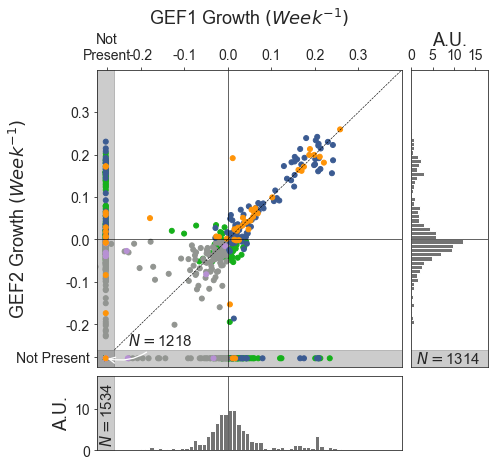

In [14]:
#Make these the same to ignore corrected status
greycol=np.array([0.45,0.45,0.45,1.0])
greycol2=np.array([0.25,0.25,0.25,1.0])
m1='o'
ms=25
def growth_scatter(x_rep, y_rep, save=False):
    #Extract the data, correct the NaNs etc

    df_t1 = df[df['type']!=-2]
    df_t1 = df_t1.sort_values(by='type', axis=0)
    grs1, grs2 = df_t1[x_rep+'_gr'], df_t1[y_rep+'_gr']
    
    #Correct the extinct BCs into the correct column
    grs1[grs1<-50.]=-0.28
    grs2[grs2<-50.]=-0.28

    freq_lim=0.4
    with sns.axes_style('ticks'):
        #Build the axes collection
        plt.figure(figsize=(7,7))
        gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[4,1]) 
        plt.subplot(gs[0])
        gs.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
        
        #Plot the scatters on the main axis
        cols = [col_list[df['type'][ix]] for ix in grs1.index]
        cols = map(lambda x : sns.xkcd_rgb['grey'] if x==abs_col else x, cols)
        sizes = [ms if df['type'][ix]==0 else ms for ix in grs1.index]
        plt.scatter(grs1, grs2, c=cols, marker=m1, s=sizes)

        #Zero marker.
        plt.gca().axvline(0.0, c='k',lw=0.6, ls='-')
        plt.gca().axhline(0.0, c='k',lw=0.6, ls='-')
        
        #Plot y=x
        plt.plot(np.arange(-0.26,10), np.arange(-0.26,10), ls='--', lw=0.6, c='k')
        
        #Main figure labels, limits and ticks
        plt.xlabel(x_rep+ r' Growth $(Week^{-1})$',size=18, labelpad=8)
        plt.ylabel(y_rep+ r' Growth $(Week^{-1})$',size=18, labelpad=-13)
        plt.xlim(-0.3,freq_lim)
        plt.ylim(-0.3,freq_lim)
        plt.xticks(np.concatenate(([-0.2775],np.arange(-0.2,0.31, 0.1))), 
               ['Not\nPresent', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3'], size=14)
        plt.yticks(np.concatenate(([-0.2775],np.arange(-0.2,0.31, 0.1))), 
               ['Not Present', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3'], size=14)
        plt.gca().xaxis.tick_top()
        plt.gca().xaxis.set_label_position('top') 
    
        #Grey area for double extinct.
        plt.gca().fill_between(np.arange(-12,12), -0.3, -0.26, zorder=0, color='k', alpha=0.2)
        plt.gca().fill_between([-0.3, -0.26], -20,10, zorder=0, color='k', alpha=0.2)
        
        #Mark the double extinct on the main plot.
        N_ext = len(filter(lambda x : x[0]<-0.2 and x[1]<-0.2, zip(grs1,grs2)))
        plt.gca().annotate(r"$N = $"+str(N_ext), size=15,
                xy=(-0.28, -0.28), xycoords='data',
                xytext=(-0.23, -0.25), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=-0.3", lw=1.3),
                )
        
        #Bottom frequency histogram
        plt.subplot(gs[1])
        
        plt.hist(grs2, bins=np.arange(-0.2,freq_lim,0.01), 
                 orientation='horizontal', normed=True, color=greycol)
        
        plt.yticks([])
        plt.xlabel('A.U.', size=18)
        plt.gca().xaxis.tick_top()
        plt.gca().xaxis.set_label_position('top') 
        plt.xticks([0,5,10,15], size=14)

        plt.gca().axhline(0.0, c='k',lw=0.6, ls='-')
        plt.gca().fill_between(np.arange(-100,100), -0.3, -0.26, zorder=0, color='k', alpha=0.2)

        N_ext = len(filter(lambda x : x< -0.2, grs2))
        plt.gca().text(1,-0.281, r'$N=$'+str(N_ext), verticalalignment='center', fontsize=15)

        plt.xlim(0,18)
        plt.ylim(-0.3,freq_lim)
        
        #Right frequency histogram
        plt.subplot(gs[2])
        plt.hist(grs1, bins=np.arange(-0.2,freq_lim,0.01), 
                 orientation='vertical', normed=True, color=greycol)

        plt.xticks([])
        plt.gca().invert_yaxis()
        plt.ylabel('A.U.', size=18)
        plt.yticks(size=14)

        plt.gca().axvline(0.0, c='k',lw=0.6, ls='-')
        plt.gca().fill_between([-0.3, -0.26], -20,20, zorder=0, color='k', alpha=0.2)
        N_ext = len(filter(lambda x : x<-0.2, grs1))
        plt.gca().text(-0.278, 1, r'$N=$'+str(N_ext), horizontalalignment='center', rotation=90,
                       fontsize=15, verticalalignment='bottom')

        plt.xlim(-0.3,freq_lim)
        plt.ylim(0,18)
        #plt.suptitle("Growth Rates for Surviving BCs",size=22)
        plt.tight_layout()
        if save:
            pass
            plt.savefig('./figs/scatters/'+x_rep+'_'+y_rep+'.svg', 
                        bbox_inches="tight", transparent=True)
            plt.savefig('./figs/scatters/'+x_rep+'_'+y_rep+'.pdf', bbox_inches="tight")
        plt.show()
        
growth_scatter('GEF1', 'GEF2', False)

# Uncomment for others

# growth_scatter('GEF1', 'GEF3', True)
# growth_scatter('GEF1', 'TRM4', True)
# growth_scatter('GEF1', 'TRM5', True)
# growth_scatter('GEF1', 'TRM6', True)

# growth_scatter('GEF2', 'GEF3', True)
# growth_scatter('GEF2', 'TRM4', True)
# growth_scatter('GEF2', 'TRM5', True)
# growth_scatter('GEF2', 'TRM6', True)

# growth_scatter('GEF3', 'TRM4', True)
# growth_scatter('GEF3', 'TRM5', True)
# growth_scatter('GEF3', 'TRM6', True)

# growth_scatter('TRM4', 'TRM5', True)
# growth_scatter('TRM4', 'TRM6', True)

# growth_scatter('TRM5', 'TRM6', True)

### Stracked growth rate plot

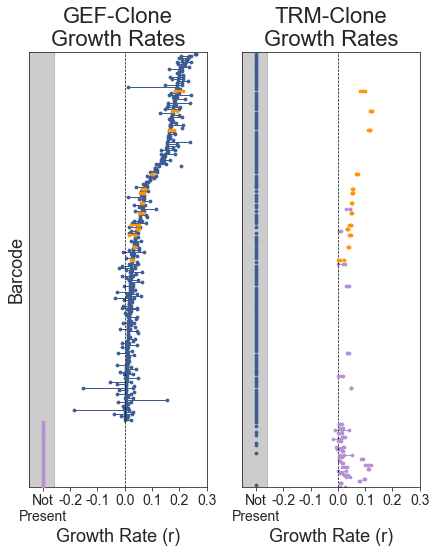

In [15]:
anotcol=sns.xkcd_rgb['tangerine']
plot_data = {}
for bc in df[df['type']>0].index:
    g1 = df[df['type']>0]['GEF1_gr'][bc]
    g2 = df[df['type']>0]['GEF2_gr'][bc]
    g3 = df[df['type']>0]['GEF3_gr'][bc]
    
    t1 = df[df['type']>0]['TRM4_gr'][bc]
    t2 = df[df['type']>0]['TRM5_gr'][bc]
    t3 = df[df['type']>0]['TRM6_gr'][bc]
    
    plot_data[bc] = (g1, g2, g3, t1, t2, t3)

#Those with positive growth rate
plot_data = {k:v for k,v in plot_data.iteritems() if np.max(v[:3])>0.0 or np.max(v[3:])>0.0}
plot_data = sorted(plot_data.items(), key=(lambda x : np.median(x[1][:3])))

with sns.axes_style('ticks'):
    plt.figure(figsize=(7,8))
    plt.subplot(121)
    for ix, v in enumerate(plot_data):
        if np.min(v[1][:3])>0.0:
            c = anotcol if np.min(v[1])>0.0 else sns.xkcd_rgb['denim blue']
            zo = 100 if np.min(v[1])>0.0 else 10
            lw = 2.0 if np.min(v[1])>0.0 else 1.0
            plt.plot(v[1][:3],[ix]*3, lw=lw, marker='.', ms=5.5, c=c, zorder=zo)
        elif len([x for x in v[1][:3] if x>0.0])>1:
            plt.plot(v[1][:3],[ix]*3, lw=1., marker='.', ms=5.5, c=sns.xkcd_rgb['denim blue'])
        else:
            plt.plot(-0.3, [ix], lw=1., marker='.', c=sns.xkcd_rgb['pale purple'],zorder=100,ms=5.5)

    plt.gca().fill_between(np.arange(-0.35, -0.25, 0.01), -400, 800, zorder=0, color='k', alpha=0.2)
    plt.ylim(0, len(plot_data))

    plt.xticks(np.arange(-0.3,0.31,0.1), ['Not\nPresent', '-0.2', '-0.1', '0.0' ,'0.1' ,'0.2' ,'0.3'], size=14)
    plt.yticks([])
    plt.ylabel('Barcode', size=18)
    plt.xlabel('Growth Rate (r)', size=18)
    plt.xlim(-0.35,0.3)
    plt.gca().axvline(0.0,ls='--', lw=0.7, c='k')
    plt.title('GEF-Clone\nGrowth Rates', size=22)
    
    plt.subplot(122)
    for ix, v in enumerate(plot_data):
        if np.min(v[1][3:])>0.0:
            c = col_list[3] if np.min(v[1])>0.0 else col_list[1]
            zo = 100 if np.min(v[1])>0.0 else 10
            plt.plot(v[1][3:],[ix]*3, lw=1., marker='.', ms=5.5, c=c, zorder=zo)
        elif len([x for x in v[1][3:] if x>0.0])>1:
            plt.plot(v[1][3:],[ix]*3, lw=1., marker='.', ms=5.5, c=sns.xkcd_rgb['pale purple'])
        else:
            plt.plot(-0.3, [ix], lw=1., marker='.', c=sns.xkcd_rgb['denim blue'],zorder=100,ms=5.5)
                    
    plt.gca().axvline(0.0,ls='--', lw=0.7, c='k')

    plt.gca().fill_between(np.arange(-0.35, -0.25, 0.01), -400, 800, zorder=0, color='k', alpha=0.2)

    
    plt.xticks(np.arange(-0.3,0.31,0.1), ['Not\nPresent', '-0.2', '-0.1', '0.0' ,'0.1' ,'0.2' ,'0.3'], size=14)
    plt.yticks([])
    plt.xlabel('Growth Rate (r)', size=18)
    plt.ylim(0, len(plot_data))
    plt.xlim(-0.35,0.3)
    plt.title('TRM-Clone\nGrowth Rates', size=22)

    plt.show()

### Scatterplots with no histograms

In [16]:
#Make these the same to ignore corrected status
greycol=np.array([0.45,0.45,0.45,1.0])
greycol2=np.array([0.25,0.25,0.25,1.0])
m1='o'
ms=25
def growth_scatter(x_rep, y_rep):
    #Extract the data, correct the NaNs etc

    df_t1 = df[df['type']!=-2]
    df_t1 = df_t1.sort_values(by='type', axis=0)
    grs1, grs2 = df_t1[x_rep+'_gr'], df_t1[y_rep+'_gr']
    
    #Correct the extinct BCs into the correct column
    grs1[grs1<-50.]=-0.28
    grs2[grs2<-50.]=-0.28

    freq_lim=0.4
    with sns.axes_style('ticks'):
        #Build the axes collection
        
        #Plot the scatters on the main axis
        cols = [col_list[df['type'][ix]] for ix in grs1.index]
        cols = map(lambda x : sns.xkcd_rgb['grey'] if x==abs_col else x, cols)
        sizes = [ms if df['type'][ix]==0 else ms for ix in grs1.index]
        plt.scatter(grs1, grs2, c=cols, marker=m1, s=sizes)

        #Zero marker.
        plt.gca().axvline(0.0, c='k',lw=0.6, ls='-')
        plt.gca().axhline(0.0, c='k',lw=0.6, ls='-')
        
        #Plot y=x
        plt.plot(np.arange(-0.26,10), np.arange(-0.26,10), ls='--', lw=0.6, c='k')
        
        #Main figure labels, limits and ticks
        plt.xlabel(x_rep+ r' Growth $(Week^{-1})$',size=18, labelpad=8)
        plt.ylabel(y_rep+ r' Growth $(Week^{-1})$',size=18, labelpad=-13)
        plt.xlim(-0.3,freq_lim)
        plt.ylim(-0.3,freq_lim)
        plt.xticks(np.concatenate(([-0.2775],np.arange(-0.2,0.31, 0.1))), 
               ['Not\nPresent', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3'], size=14)
        plt.yticks(np.concatenate(([-0.2775],np.arange(-0.2,0.31, 0.1))), 
               ['Not Present', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3'], size=14)
        plt.gca().xaxis.tick_top()
        plt.gca().xaxis.set_label_position('top') 
    
       #Grey area for double extinct.
        plt.gca().fill_between(np.arange(-12,12), -0.3, -0.26, zorder=0, color='k', alpha=0.2)
        plt.gca().fill_between([-0.3, -0.26], -20,10, zorder=0, color='k', alpha=0.2)
        
        N_ext = len(filter(lambda x : x< -0.2, grs2))
        plt.gca().text(0.24,-0.281, r'$N=$'+str(N_ext), verticalalignment='center', fontsize=15)
        
        N_ext = len(filter(lambda x : x<-0.2, grs1))
        plt.gca().text(-0.278, 0.24, r'$N=$'+str(N_ext), horizontalalignment='center', rotation=90,
                       fontsize=15, verticalalignment='bottom')
        
        #Mark the double extinct on the main plot.
        N_ext = len(filter(lambda x : x[0]<-0.2 and x[1]<-0.2, zip(grs1,grs2)))
        plt.gca().annotate(r"$N = $"+str(N_ext), size=15,
                xy=(-0.28, -0.28), xycoords='data',
                xytext=(-0.23, -0.25), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=-0.3", lw=1.3),
                )

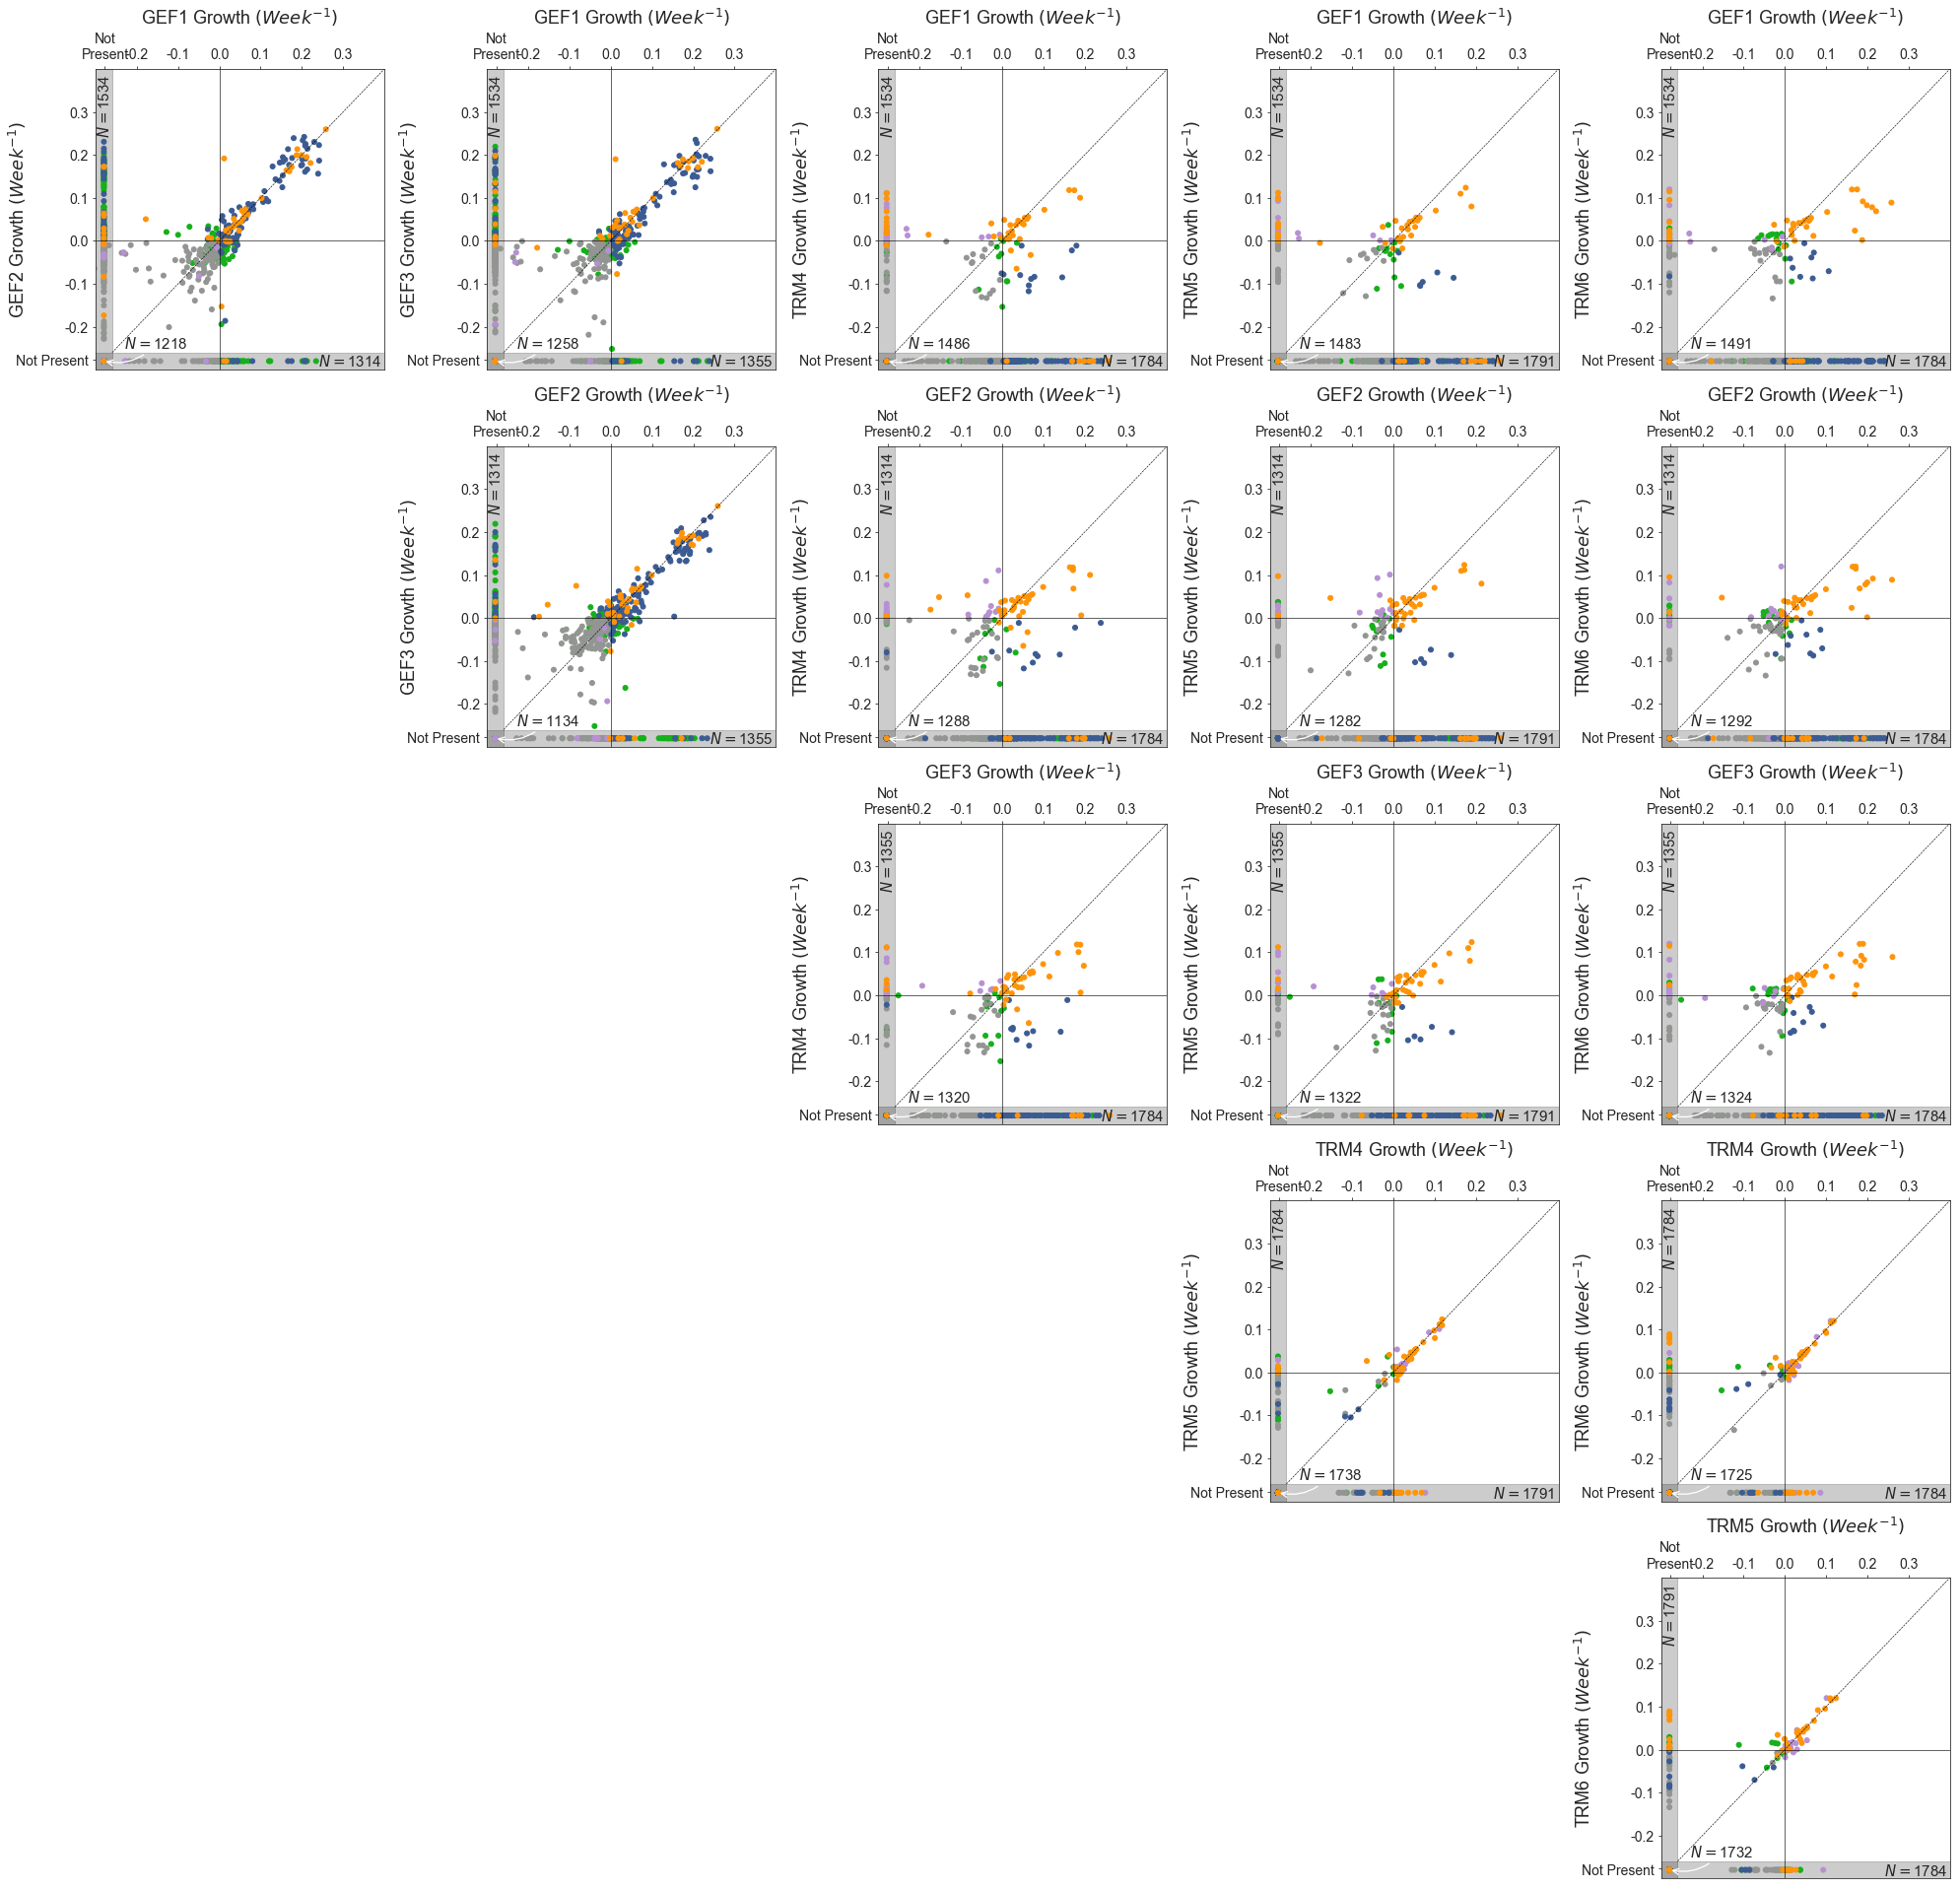

In [17]:
#Builds a grid of scatter plots.
reps = ['GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6']
plt.figure(figsize=(32,32))
for ix1, rep1 in enumerate(reps):
    for ix2, rep2 in enumerate(reps):
        if ix2>ix1:
            plt.subplot(len(reps), len(reps), ix1*len(reps)+ix2+1)
            growth_scatter(rep1, rep2)
    
plt.tight_layout()
plt.show()
